## Tratamiendo de los datos de SONDA

In [1]:

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#Preprocesamiento de las caracteristicas 

def preprocess_features(raw_data):
    selected_features = raw_data[['Fecha de creación','Tema', 'Fecha de cierre real', 'Monto total', 'Modalidad', 'Naturaleza de Oportunidad']]
    selected_features['Fecha de cierre real'] = pd.to_datetime(selected_features['Fecha de cierre real'])
    selected_features['Fecha de creación'] = pd.to_datetime(selected_features['Fecha de creación'])
    selected_features['Duracion en dias'] = selected_features['Fecha de cierre real'] - selected_features['Fecha de creación']
      
    processed_features = selected_features.copy()
    
    processed_features['Monto total'] = processed_features['Monto total'] / raw_data['Tasa de Cambio']
    
    
    
    return processed_features
    
#Suma el valor de las oportunidades cerradas hasta la fecha entregada como parametro
#def op_sum_to_date(date, features):
#    return features['Monto total'].where(features['Fecha de cierre real'] <= date).sum()
    

In [5]:
#oportunidades.sort_values(by='Fecha de cierre real')
oportunidades = pd.read_csv("oportunidades.csv")


features = preprocess_features(oportunidades)

oportunidades.head()



/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4,5,17,20,21,26,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


KeyError: "['Fecha de creación' 'Tema' 'Fecha de cierre real' 'Monto total'\n 'Modalidad' 'Naturaleza de Oportunidad'] not in index"

Text(0,0.5,'Distribuición de las duraciónes')

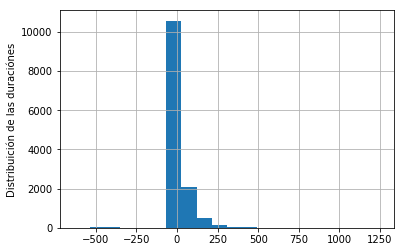

In [4]:
#features.set_index('Fecha de cierre real')
aux = []
for days in features['Duracion en dias']:
    val = str(days).split(' ')
    aux.append(val[0])
for i in range(0, len(aux)-1):
    aux[i] = int(aux[i])
aux[-1] = 0


features['duracion'] = aux
features['duracion'].hist(bins=20).set_ylabel("Distribuición de las duraciónes")

Text(0,0.5,'Miles de Dolares')

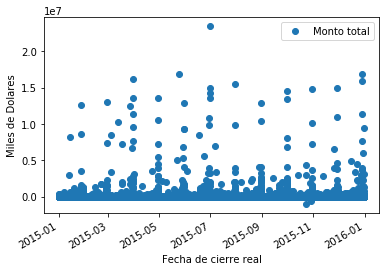

In [5]:
features.plot(x='Fecha de cierre real', y='Monto total', style='o').set_ylabel("Miles de Dolares")


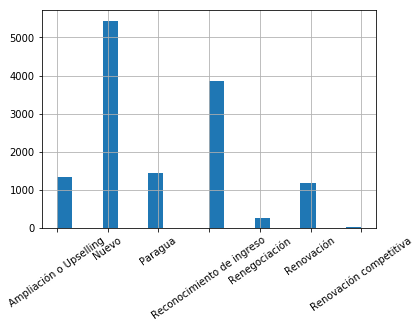

In [6]:
features['Naturaleza de Oportunidad'].hist(bins=20, xrot = 35)


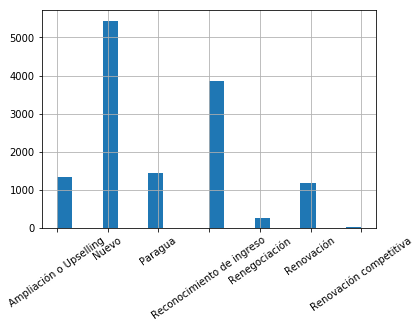

In [7]:
features['Naturaleza de Oportunidad'].hist(bins=20, xrot = 35)

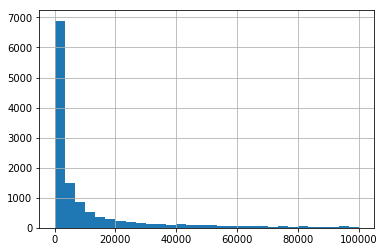

In [8]:
features['Monto total'].hist(bins=30,range=(0, 1E5 ))
#features['Monto total'].hist(bins=30)

([<matplotlib.patches.Wedge at 0x1a22087710>,
 [Text(1.04561,0.341609,'Under'), Text(-1.04561,-0.341609,'Over')],
 [Text(0.570334,0.186332,'10.1%'), Text(-0.570334,-0.186332,'89.9%')])

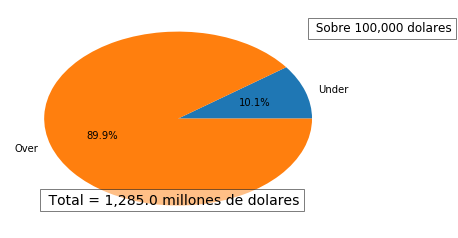

In [9]:
var = 100000
under = features['Monto total'].where(features['Monto total'] < var).sum()
over = features['Monto total'].where(features['Monto total'] >= var).sum()
total = features['Monto total'].sum()

labels = ['Under', 'Over']
fracs = under/total, over/total

total_by_thousand = total/1000000
plt.text(1,1, r' Sobre '+format(var, ',') +' dolares', bbox=dict(facecolor='white', alpha=0.5), fontsize=12)  
plt.text(-1,-0.98, r' Total = ' + format(round(total_by_thousand), ',') + ' millones de dolares', bbox=dict(facecolor='white', alpha=0.5), fontsize=14)  
plt.pie(fracs, labels=labels, autopct='%1.1f%%')


## Por hacer


El problema con la data es que todas las oportunidades son ganadas por lo que el modelo no puede aprender nada de ellas.

También falta pasar características como `Modalidad` y `Naturaleza de Oportunidad` a one-hot encoding.

### Dudas 

* La `modalidad`, ¿tiene dos posibilidades solamente `venta` y `servicio mensual`?
* Lo mismo con la linea de negocios, en la base de datos aparecen solamente `Plataforma` y `Outsourcing`
* ¿Existe un registro de las oportunidades perdidas también?





## Como funciona el algoritmo

Dos ideas.

1. Prediccion de la probabilidad de cierre de una oportunidad abierta. 

>En este caso, debemos analizar todos los datos, tanto oportunidades perdidas como ganadas, de manera que nuestro modelo aprenda a clasificar una nueva oportunidad como probable o no. Para esto debemos analisar si todos los parametros de una oportunidad que sean buenos indicadores de que la oportunidad va a cerrar y ser ganada o perdida.

2. Analisis historico de ventas.

>En este caso, tomariamos en cuenta solo los datos historicos del total vendido por sonda –por mes, por año, por semana– y trataríamos de estimar en base al comportamiento que se dibuje en estos datos una predicción para las ventas futuras.
